# Personalized Cancer Diagnosis

## [ CONTENTS ] 

1. About the dataset<br>
2. Real-world/Business objectives and constraints<br>
3. Data and Libraries Loading<br>
4. Exploratory Data Analysis
4. Data Preprocessing <br>
5. Naive Bayes on k-Fold cross validation<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Summary<br>

## 1. About the dataset
1. **Title:** Personalized Cancer Diagnosis. Link:https://www.kaggle.com/c/msk-redefining-cancer-treatment/ 
2. **Data:** Memorial Sloan Kettering Cancer Center (MSKCC)
3. **Task:** Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
4. **Relevant Info:** There are nine different classes a genetic mutation can be classified on. This is not a trivial task since interpreting clinical evidence is very challenging even for human specialists. Therefore, modeling the clinical evidence (text) will be critical.
5. **Data includes:**
    * **training_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are <i>ID</i> (the id of the row used to link the mutation to the clinical evidence), <i>Gene</i> (the gene where this genetic mutation is located), <i>Variation</i> (the amino-acid change for this mutations), <i>Class</i> (1-9 the class this genetic mutation has been classified on)
    * **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

## 2. Real-world/Business objective and constraints


**Objective:** Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
<br>
<br>**Constraints:**
<br>
* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

## 3. Data and Libraries Loading

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [4]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## 4. Data Preprocessing

In [6]:
stop_words = set(stopwords.words('english')) 

def txt_preprocessing(total_txt, index, col):
    
    if type(total_txt) is not int:
        string = ''
        total_txt = re.sub('[^a-zA-Z0-9\n]', ' ', total_txt)
        total_txt = re.sub('\s+', ' ', total_txt)
        total_txt = total_txt.lower()
        
        for word in total_txt.split():
            if not word in stop_words:
                string += word + ' '
                
        data_text[col][index] = string

In [7]:
#txt_preprocessing runner 
tic = time.time()

for index, row in data_text.iterrows():
    
    if type(row['TEXT']) is str:
        txt_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

print('Time took for preprocessing the text :', time.time() - tic, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 150.37923884391785 seconds


In [8]:
complete_data = pd.merge(data, data_text, on = 'ID', how = 'left')
complete_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
complete_data[complete_data['TEXT'].isnull()]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
complete_data['TEXT'][complete_data['TEXT'].isnull()] = complete_data['Gene'] +' '+complete_data['Variation']

In [11]:
complete_data[complete_data['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [12]:
y_true = complete_data['Class'].values
complete_data.Gene = complete_data.Gene.str.replace('\s+', '_')
complete_data.Variation = complete_data.Variation.str.replace('\s+', '_')

In [84]:
def data_split(complete_data, ytrue):
    
    train_x, test_x, train_y, test_y = train_test_split(complete_data, y_true,
                                                        stratify = y_true, test_size = 0.2,
                                                        random_state = 24)
    train_x = train_x.drop(['Class'], axis = 1)
    test_x = test_x.drop(['Class'], axis = 1)
    
    return train_x, test_x, train_y, test_y

In [62]:
from sklearn.preprocessing import StandardScaler

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

In [75]:
from sklearn.preprocessing import MaxAbsScaler

def max_abs(data):
    maxabs = MaxAbsScaler()
    result = maxabs.fit_transform(data)
    return result

### 4.1 Categorical Variable Encoding

### [A] One Hot Encode

In [55]:
from sklearn.preprocessing import LabelBinarizer

def onehot_encode(fitter, convert, categories):
    
    encode = LabelBinarizer()
    fit_encoded = encode.fit_transform(fitter)
    encoded = encode.transform(convert)

    fit_encoded = pd.SparseDataFrame(fit_encoded, columns = categories).fillna(0)
    encoded = pd.SparseDataFrame(encoded, columns = categories).fillna(0)
    
    return fit_encoded, encoded

### [B] Response Encode

In [16]:
from tqdm import tqdm

def feature_dictionary(data, ydata, feature, alpha):
    
    value_count = data[feature].value_counts()
    dict_format = dict()
    
    for i, j in value_count.items():
        vec = []
        for k in range(1, 10):
            class_count = data[(ydata == k) & (data[feature] == i)]
            vec.append((class_count.shape[0] + alpha * 90) / (j + 90 * alpha))
        dict_format[i] = vec
    
    return dict_format

def response_encode(trn_data, ydata, tst_data, feature, alpha):
    
    feature_dict = feature_dictionary(trn_data, ydata, feature, alpha)
    value_count = trn_data[feature].value_counts()
    trn_encoded = []
    
    for index, row in trn_data.iterrows():
        if row[feature] in dict(value_count).keys():
                trn_encoded.append(feature_dict[row[feature]])
        
        else:
                trn_encoded.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
                
    tst_encoded = []
    
    for index, row in tst_data.iterrows():
        if row[feature] in dict(value_count).keys():
                tst_encoded.append(feature_dict[row[feature]])
        
        else:
                tst_encoded.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
            
    return trn_encoded, tst_encoded

### 4.2 TEXT Encoding and Vectorization

In [17]:
import math

def text_response_encode(data, ydata, total_dict, dict_list):
    
    encoded = np.zeros((data.shape[0], 9))
        
    for i in range(0, 9):
        row_index = 0
        for index, row in data.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word, 0)+10) / (total_dict.get(word, 0) + 90)))
            encoded[row_index][i] = math.exp(sum_prob / len(row['TEXT'].split()))
            row_index += 1
    
    return encoded

In [98]:
def unique_words(data, labels):
    
    train_x, test_x, train_y, test_y = data_split(data, labels)
    text_vect = CountVectorizer(min_df = 3, stop_words = 'english')
    fit_vect = text_vect.fit(train_x['TEXT'])
    train_features = text_vect.get_feature_names()
    
    #train_feature_count = np.sum(fit_vect, axis = 0)
    #txt_feature_dict = dict(zip(list(train_features), train_feature_count))
    print('Total Number of Unique Words in Train Data : ', len(train_features))

In [99]:
def text_onehot_encode(train_data, test_data):
    
    text_vect = CountVectorizer(min_df = 3, stop_words = 'english')
    fit_vect = text_vect.fit(train_data['TEXT'])
    train_vect = fit_vect.transform(train_data['TEXT'])
    test_vect = fit_vect.transform(test_data['TEXT'])
    features = text_vect.get_feature_names()
    
    train_vect = normalize(train_vect, axis=0)
    test_vect = normalize(test_vect, axis=0)

    where_are_NaNs = pd.isnull(train_vect)
    train_vect[where_are_NaNs] = 0
    where_are_NaNs = pd.isnull(test_vect)
    test_vect[where_are_NaNs] = 0
    
    train_vect = pd.SparseDataFrame(train_vect, columns = features).fillna(0)
    test_vect = pd.SparseDataFrame(test_vect, columns = features).fillna(0)
    
    return train_vect, test_vect

In [ ]:
def something(data, labels):
    
    train_x, test_x, train_y, test_y = data_split(data, labels)
    dict_list = []
    for i in range(1, 10):
        cls_text = train_x[train_y == i]
        dict_list.append(extract_dic(cls_text))

    total_dict = extract_dic(train_x['TEXT'])

    confuse_array = []
    for i in train_text_features:
        ratios = []
        max_val = -1
        for j in range(0,9):
            ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
        confuse_array.append(ratios)
    confuse_array = np.array(confuse_array)

## 5. Exploratory Data Analysis 

In [20]:
def distribution_check(data):
    classes = np.unique(data)
    freq_counts = []
    for c in classes:
        class_count = np.array(data == c).sum()
        freq_counts.append(class_count)
    for i, c in enumerate(list(classes)):
        print('Number of Data Points in Class {} is {} ({}%)'.format(classes[i],
                                                                     freq_counts[i],
                                                                     np.round(freq_counts[i] * 100 / len(data))))
    distribution_plot(classes, freq_counts)

In [21]:
def distribution_plot(classes, freq_counts):
    sns.set()
    my_color = 'RdPu'
    plt.figure(figsize=(8, 5))
    sns.barplot(x = classes, y = freq_counts, palette="winter",)
    plt.title('Class Distribution plot')
    plt.xlabel('Class Labels')
    plt.ylabel('Count')
    plt.show()

Number of Data Points in Class 1 is 454 (17.09%)
Number of Data Points in Class 2 is 361 (13.59%)
Number of Data Points in Class 3 is 71 (2.67%)
Number of Data Points in Class 4 is 549 (20.67%)
Number of Data Points in Class 5 is 194 (7.3%)
Number of Data Points in Class 6 is 220 (8.28%)
Number of Data Points in Class 7 is 762 (28.69%)
Number of Data Points in Class 8 is 15 (0.56%)
Number of Data Points in Class 9 is 30 (1.13%)


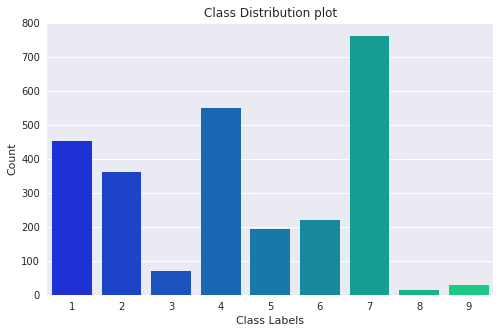

In [145]:
distribution_check(train_y)

Number of Data Points in Class 1 is 114 (17.14%)
Number of Data Points in Class 2 is 91 (13.68%)
Number of Data Points in Class 3 is 18 (2.71%)
Number of Data Points in Class 4 is 137 (20.6%)
Number of Data Points in Class 5 is 48 (7.22%)
Number of Data Points in Class 6 is 55 (8.27%)
Number of Data Points in Class 7 is 191 (28.72%)
Number of Data Points in Class 8 is 4 (0.6%)
Number of Data Points in Class 9 is 7 (1.05%)


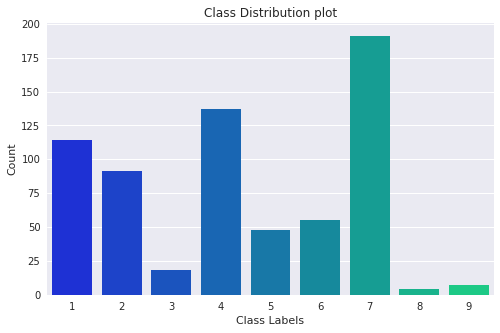

In [146]:
distribution_check(test_y)

### 5.1 Univariate Analysis 

In [22]:
def dist_plot(data, feature):
    
    sns.set()
    plt.figure(figsize = (10, 5))
    sns.distplot(data.values, color = 'b')
    plt.xlabel('Index of Gene')
    plt.ylabel('Num of Occurrence')
    plt.title('Distribution Plot for ' + feature)
    plt.show()
    
    plt.figure(figsize = (10, 5))
    plt.plot(np.cumsum(data.values / sum(data.values)), color = 'b')
    plt.xlabel('Index of Gene')
    plt.ylabel('Cumulative Sum')
    plt.title('Cumulative Distribuition of ' + feature)
    plt.show()  

### [A] Gene

In [186]:
unique_genes = train_x['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
unique_genes.head(10)

Number of Unique Genes : 254


BRCA1     222
TP53      126
EGFR      110
BRCA2      98
PTEN       94
KIT        76
BRAF       70
ERBB2      59
ALK        53
PDGFRA     51
Name: Gene, dtype: int64

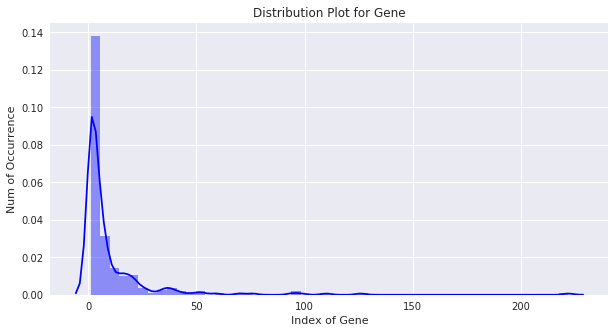

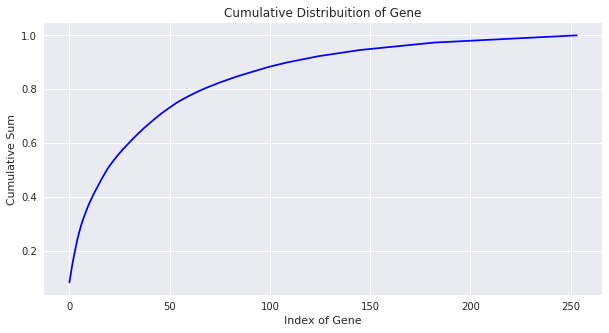

In [213]:
dist_plot(unique_genes, 'Gene')

### [B] Variation

In [214]:
unique_genes = train_x['Variation'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
unique_genes.head(10)

Number of Unique Genes : 2407


Truncating_Mutations    79
Deletion                58
Amplification           56
Fusions                 26
Overexpression           4
G12V                     3
Q61L                     3
F384L                    2
S222D                    2
P130S                    2
Name: Variation, dtype: int64

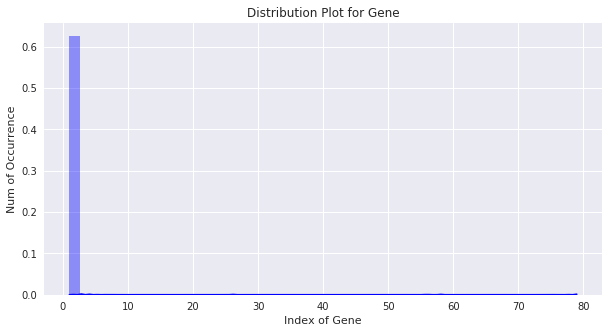

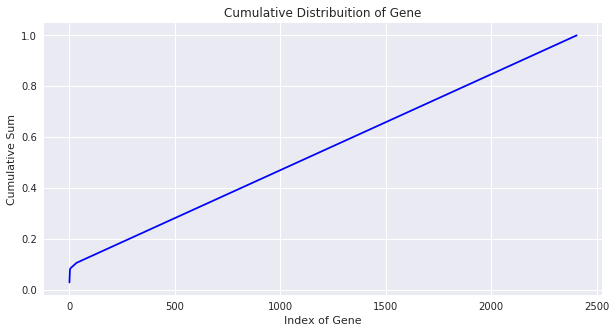

In [215]:
dist_plot(unique_genes, 'Gene')

In [23]:
def extract_dict(data):
    
    dictionary = defaultdict(int)
    for index, row in data.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    
    return dictionary

In [359]:
vectorizer(complete_data, y_true)

Total Number of Unique Words in Train Data :  58810


## 6. Prediction using a 'Random' Model 

In [24]:
from sklearn.metrics import classification_report

def random_clf(ytrain, ytest):

    ytrain_dummy = np.zeros((1, len(np.unique(ytrain))))
    ytest_dummy = np.zeros((1, len(np.unique(ytest))))
    
    for i in range(len(ytrain)):
        random_probs = np.random.rand(1, len(np.unique(ytrain)))
        ytrain_dummy = np.vstack([ytrain_dummy, random_probs / random_probs.sum()])
    print('Log-Loss on Train-set using Random Model is ', log_loss(ytrain, ytrain_dummy[1:, :]))
    err_metrics(ytrain, np.argmax(ytrain_dummy[1:, :], axis = 1) + 1)
        
    for i in range(len(ytest)):
        random_probs = np.random.rand(1, len(np.unique(ytest)))
        ytest_dummy = np.vstack([ytest_dummy, random_probs / random_probs.sum()])
    print('Log-Loss on Test-set using Random Model is ', log_loss(ytest, ytest_dummy[1:, :]))
    err_metrics(ytest, (np.argmax(ytest_dummy[1:, :], axis = 1)) + 1)

In [25]:
def err_metrics(y, yhat):
    
    confuzn_mtx = confusion_matrix(y, yhat)
    precision_mtx = confuzn_mtx / confuzn_mtx.sum(axis = 0)
    recall_mtx = (confuzn_mtx.T / confuzn_mtx.sum(axis = 1)).T
    labels = np.unique(y)
    
    print('-'*40, 'CONFUSION-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(confuzn_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*40, 'PRECISION-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(precision_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*40, 'RECALL-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(recall_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log-Loss on Train-set using Random Model is  2.4722168868777294
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


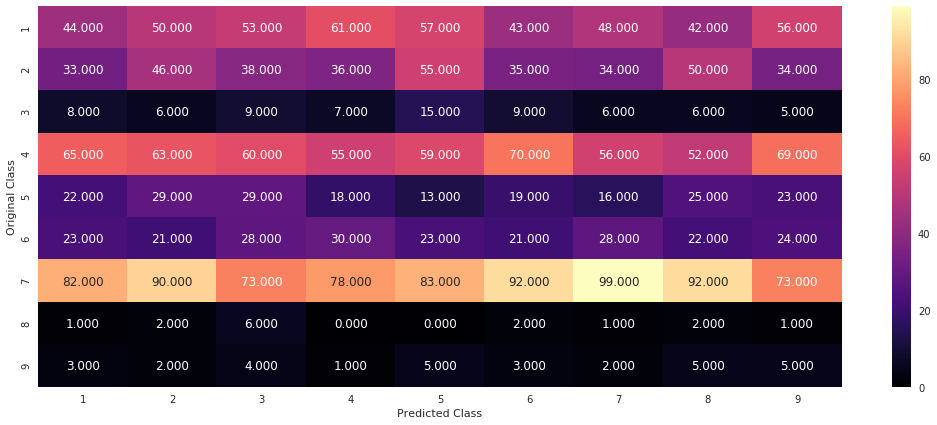

---------------------------------------- PRECISION-MATRIX ----------------------------------------


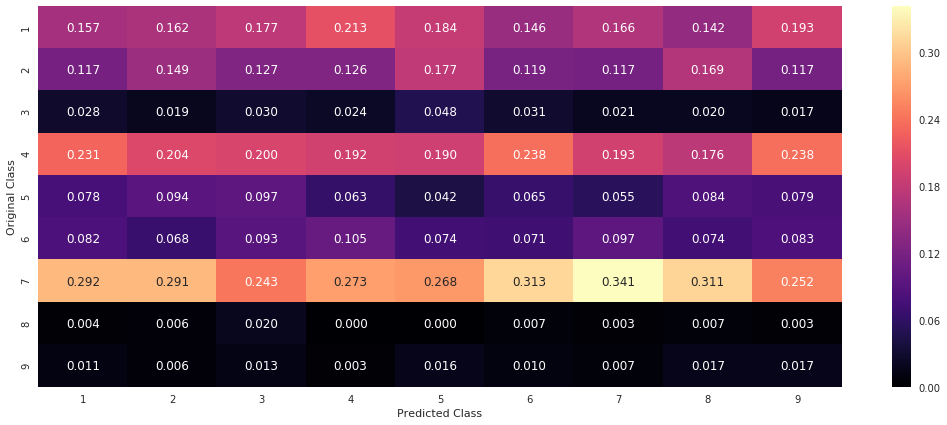

---------------------------------------- RECALL-MATRIX ----------------------------------------


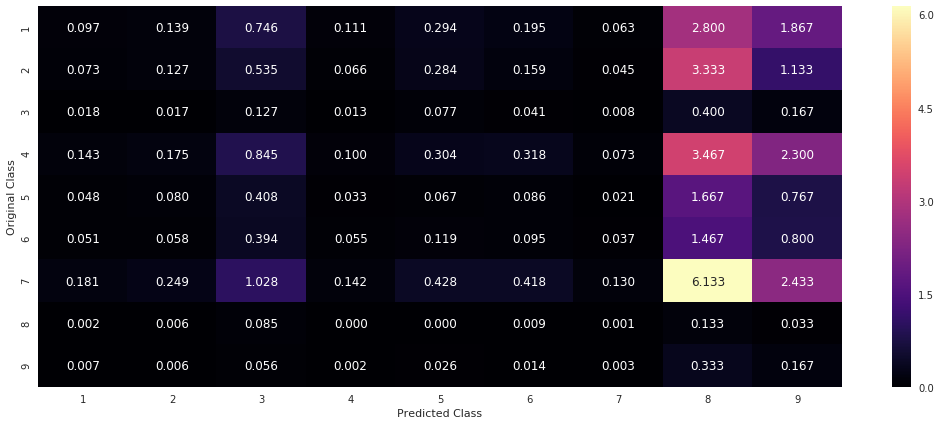

Log-Loss on Test-set using Random Model is  2.5232397824405464
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


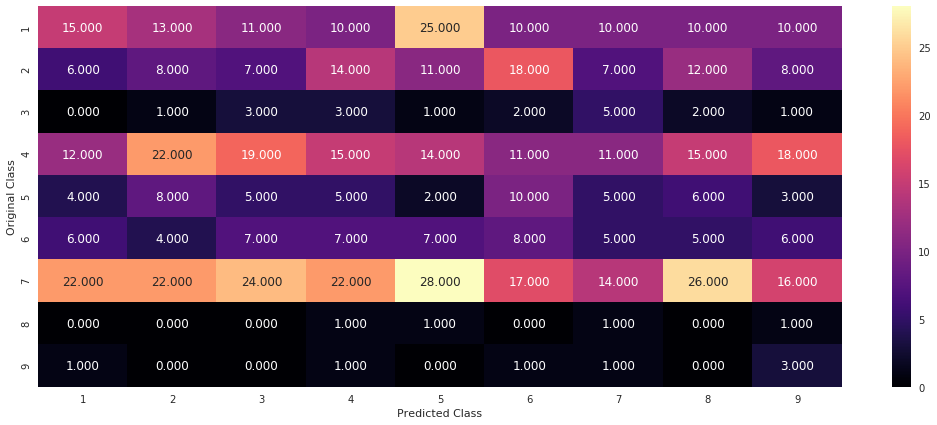

---------------------------------------- PRECISION-MATRIX ----------------------------------------


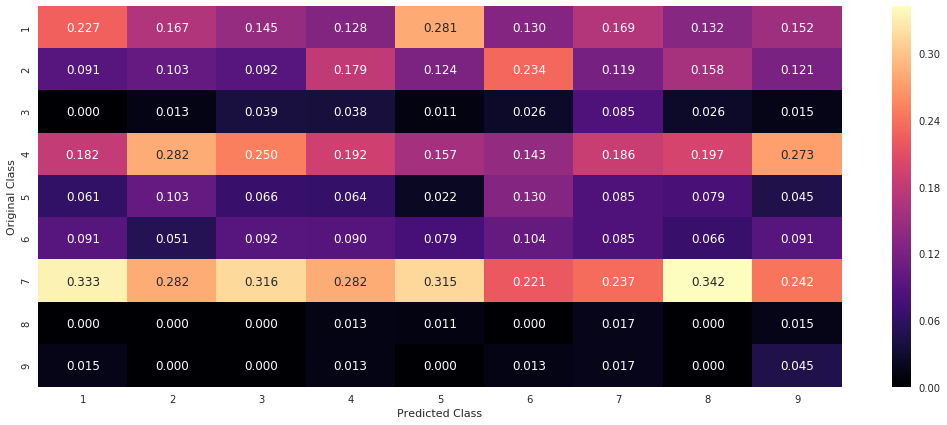

---------------------------------------- RECALL-MATRIX ----------------------------------------


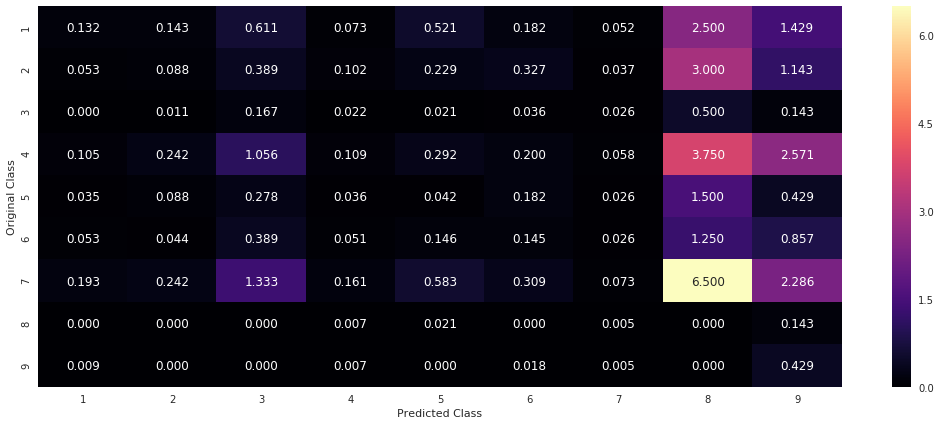

In [185]:
random_clf(train_y, test_y)

## 7. Feature Importance 

In [26]:
def feature_importance(data, labels, feature, encode_type, operation, best_alpha = None):
    
    train_x, test_x, train_y, test_y = data_split(data, labels)
    k_fold = StratifiedKFold(train_y, shuffle = True, random_state = 32)
    alpha = [10 ** x for x in range(-5, 1)]
    logloss_trn = []
    logloss_cv = []

    if operation == 'Training' and feature != 'TEXT':
        for i in alpha:
            for train, cv in k_fold:
                
                if encode_type == 'OneHotEncode':
                    trn_x, cv_x = onehot_encode(train_x.iloc[train][feature], train_x.iloc[cv][feature])
                else:
                    trn_x, cv_x = response_encode(train_x.iloc[train], train_y[train], train_x.iloc[cv], feature, 0.0001)
    
                clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 32)
                clf.fit(trn_x, train_y[train])
            
                trn_predproba = clf.predict_proba(trn_x)
                cv_predproba = clf.predict_proba(cv_x)
            
                logloss_trn.append(log_loss(train_y[train], trn_predproba))
                logloss_cv.append(log_loss(train_y[cv], cv_predproba))
        
        err_curve_sgd(logloss_trn, logloss_cv, alpha)
    
    elif operation == 'Testing' and feature != 'TEXT':
        if encode_type == 'OneHotEncode':
            trn_x, tst_x = onehot_encode(train_x[feature], test_x[feature])
        else:
            trn_x, tst_x = response_encode(train_x, train_y, test_x, feature, 0.0001)
    
        clf = SGDClassifier(alpha = best_alpha, penalty = 'l2', loss = 'log', random_state = 32)
        clf.fit(trn_x, train_y)
        
        trn_predproba = clf.predict_proba(trn_x)
        tst_predproba = clf.predict_proba(tst_x)

        print('Log-Loss For Train-Set is :', log_loss(train_y, trn_predproba))
        print('Log-Loss For Test-set is  :', log_loss(test_y, tst_predproba))
        
    elif operation == 'Training' and feature == 'TEXT':
        for i in alpha:
            for train, cv in k_fold:
                
                if encode_type == 'OneHotEncode':
                    trn_x, cv_x = text_onehot_encode(train_x.iloc[train], train_x.iloc[cv])
                else:
                    total_dict = extract_dict(train_x.iloc[train])
                    dict_list = []
    
                    for i in range(1,10):
                        cls_text = train_x.iloc[train][train_y[train] == i]
                        dict_list.append(extract_dict(cls_text))
                
                    trn_x = text_response_encode(train_x.iloc[train], train_y[train],
                                                 total_dict, dict_list)
                    cv_x = text_response_encode(train_x.iloc[cv], train_y[cv],
                                                total_dict, dict_list)
    
                clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 32)
                clf.fit(trn_x, train_y[train])
            
                trn_predproba = clf.predict_proba(trn_x)
                cv_predproba = clf.predict_proba(cv_x)
                
                trn_predproba = np.nan_to_num(trn_predproba)
                cv_predproba = np.nan_to_num(cv_predproba)
            
                logloss_trn.append(log_loss(train_y[train], trn_predproba))
                logloss_cv.append(log_loss(train_y[cv], cv_predproba))
        
        err_curve_sgd(logloss_trn, logloss_cv, alpha)
        
    else:
        if encode_type == 'OneHotEncode':
            trn_x, tst_x = text_onehot_encode(train_x, test_x)
        else:
            total_dict = extract_dict(train_x)
            dict_list = []
        
            for i in range(1,10):
                cls_text = train_x[train_y == i]
                dict_list.append(extract_dict(cls_text))
        
            trn_x = text_response_encode(train_x, train_y,
                                         total_dict, dict_list)
            tst_x = text_response_encode(test_x, test_y,
                                         total_dict, dict_list)
    
        clf = SGDClassifier(alpha = best_alpha, penalty = 'l2', loss = 'log', random_state = 32)
        clf.fit(trn_x, train_y)
        
        trn_predproba = clf.predict_proba(trn_x)
        tst_predproba = clf.predict_proba(tst_x)
        
        trn_predproba = np.nan_to_num(trn_predproba)
        tst_predproba = np.nan_to_num(tst_predproba)

        print('Log-Loss For Train-Set is :', log_loss(train_y, trn_predproba))
        print('Log-Loss For Test-set is  :', log_loss(test_y, tst_predproba))

In [27]:
def err_curve_sgd(train_loss, cv_loss, alpha):
    
    train_err = np.reshape(train_loss, (3, 6))
    cv_err = np.reshape(cv_loss, (3, 6))
    
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize = (9, 12))
        plt.subplot(3, 1, i+1)
        plt.plot(alpha, cv_err[i, :], label = 'cv_error', color = 'r')
        plt.plot(alpha, train_err[i, :], label = 'train_error', color = 'b')
        plt.xscale('log')
        plt.xlabel('Alpha-Values')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TRAIN-ERR for Fold ' + str(i + 1))
        plt.show()

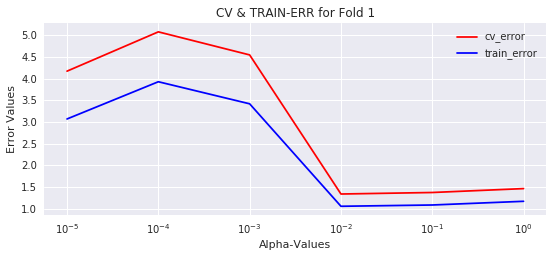

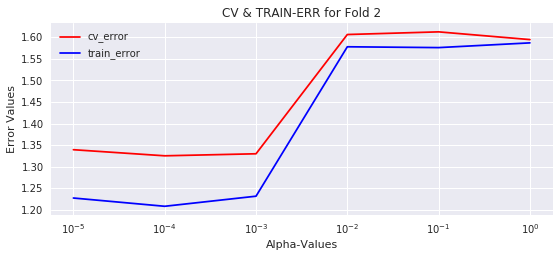

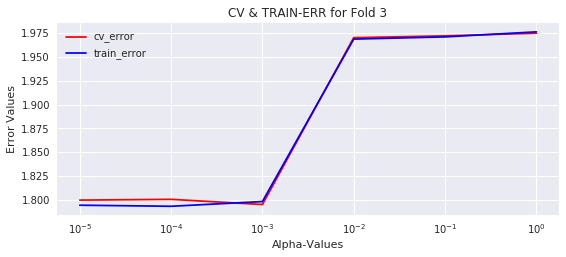

In [265]:
feature_importance(complete_data, y_true, 'Gene', 'OneHotEncode', 'Training')

In [275]:
feature_importance(complete_data, y_true, 'Gene', 'OneHotEncode', 'Testing', 0.001)

Log-Loss For Train-Set is : 1.2402576240685665
Log-Loss For Test-set is  : 1.3485597295277252


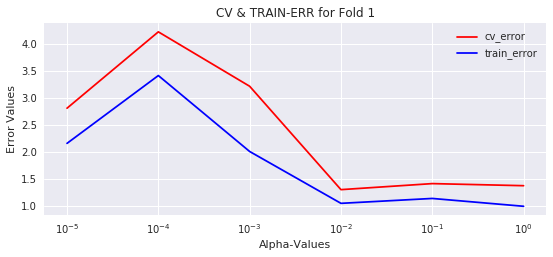

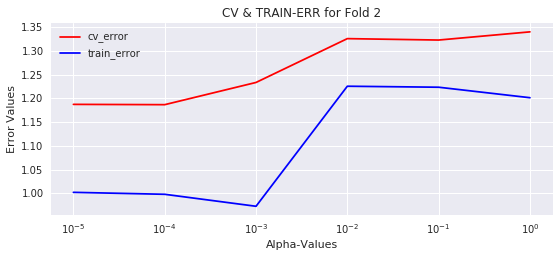

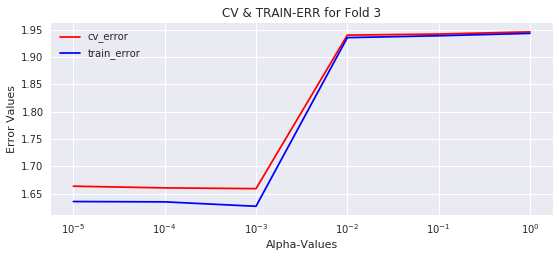

In [307]:
feature_importance(complete_data, y_true, 'Gene', 'ResponseEncode', 'Training')

In [311]:
feature_importance(complete_data, y_true, 'Gene', 'ResponseEncode', 'Testing', 0.0001)

Log-Loss For Train-Set is : 1.052788121949119
Log-Loss For Test-set is  : 1.3247662149278838


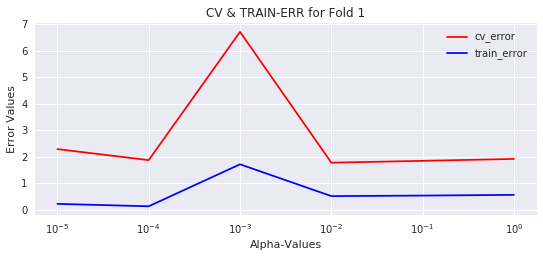

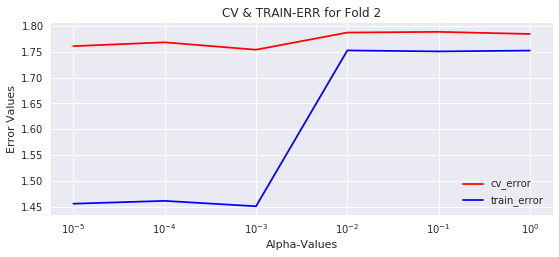

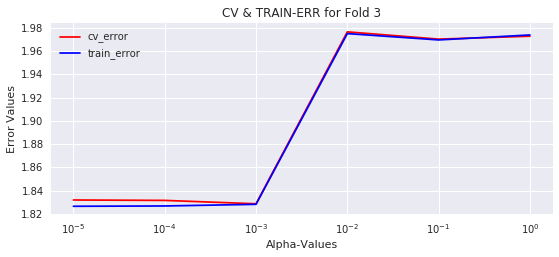

In [276]:
feature_importance(complete_data, y_true, 'Variation', 'OneHotEncode', 'Training')

In [277]:
feature_importance(complete_data, y_true, 'Variation', 'OneHotEncode', 'Testing', 0.0001)

Log-Loss For Train-Set is : 0.6612669444952577
Log-Loss For Test-set is  : 1.8159392595488655


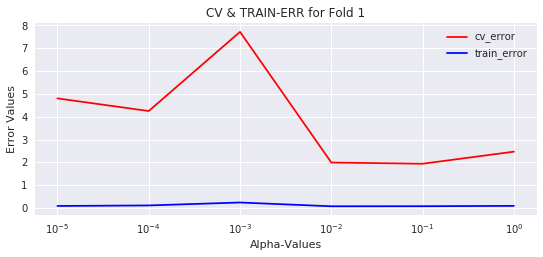

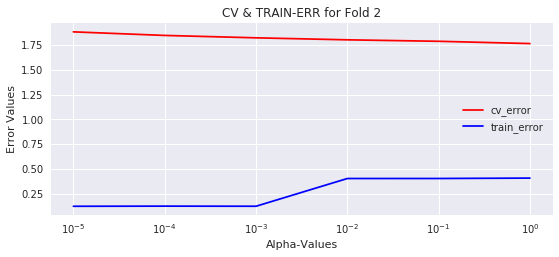

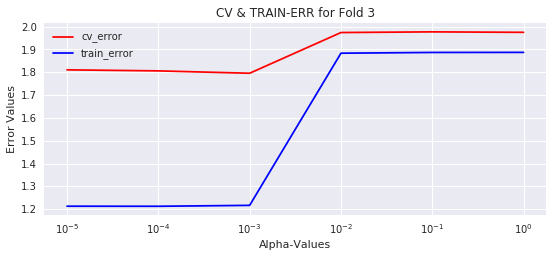

In [312]:
feature_importance(complete_data, y_true, 'Variation', 'ResponseEncode', 'Training')

In [313]:
feature_importance(complete_data, y_true, 'Variation', 'ResponseEncode', 'Testing', 0.0001)

Log-Loss For Train-Set is : 0.07503615099137982
Log-Loss For Test-set is  : 1.9725345135106742


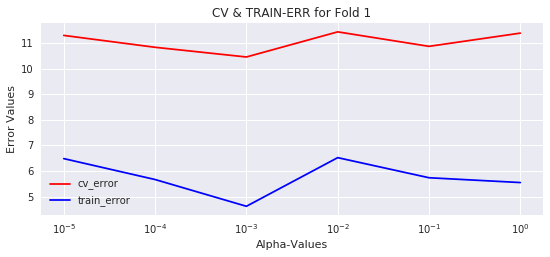

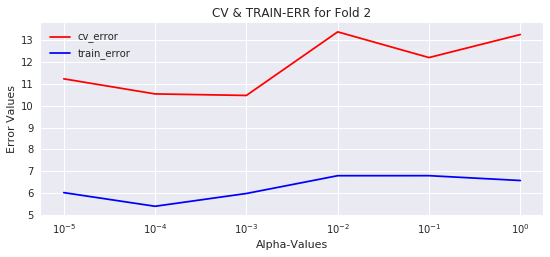

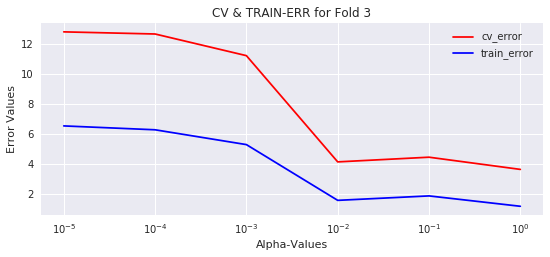

In [385]:
feature_importance(complete_data, y_true, 'TEXT', 'OneHotEncode', 'Training')

In [394]:
feature_importance(complete_data, y_true, 'TEXT', 'OneHotEncode', 'Testing', 10)

Log-Loss For Train-Set is : 0.8694753128347561
Log-Loss For Test-set is  : 1.2229933664518597


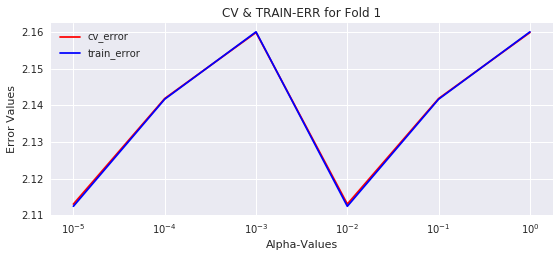

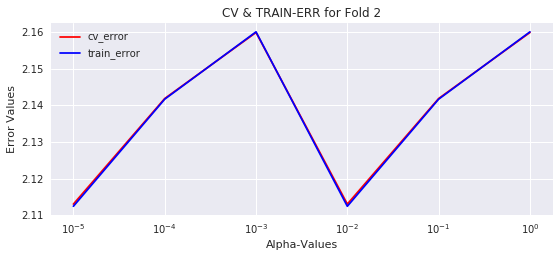

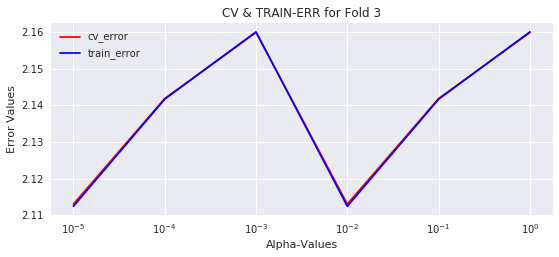

In [345]:
feature_importance(complete_data, y_true, 'TEXT', 'ResponseEncode', 'Training')

In [349]:
feature_importance(complete_data, y_true, 'TEXT', 'ResponseEncode', 'Testing', 0.01)

Log-Loss For Train-Set is : 1.7672815413167489
Log-Loss For Test-set is  : 1.7733603380520655


## 8. Machine Learning Models

### [A] Stacking All Features

In [101]:
def feature_stack(trn_data, trn_ydata, tst_data, tst_ydata, encode_type):
    
    if encode_type == 'OneHotEncode':
        
        gene_cat = np.unique(trn_data['Gene'])
        var_cat = np.unique(trn_data['Variation'])
        trn_gene, tst_gene = onehot_encode(trn_data['Gene'], tst_data['Gene'], gene_cat)
        trn_var, tst_var = onehot_encode(trn_data['Variation'], tst_data['Variation'], var_cat)
        trn_txt, tst_txt = text_onehot_encode(trn_data, tst_data)
        
        #print(trn_gene.shape, trn_var.shape, trn_txt.shape)
        total_trn_data = pd.concat([trn_gene, trn_var], axis = 1)
        total_trn_data = pd.concat([total_trn_data, trn_txt], axis = 1)
        total_tst_data = pd.concat([tst_gene, tst_var], axis = 1)
        total_tst_data = pd.concat([total_tst_data, tst_txt], axis = 1)
        
    else:
        total_dict = extract_dict(trn_data)
        dict_list = []
        
        for i in range(1,10):
            cls_text = trn_data[trn_ydata == i]
            dict_list.append(extract_dict(cls_text))
        
        trn_gene, tst_gene = response_encode(trn_data, trn_ydata, tst_data, 'Gene', 0.0001)
        trn_var, tst_var = response_encode(trn_data, trn_ydata, tst_data, 'Variation', 0.0001)
        trn_txt = text_response_encode(trn_data, trn_ydata, total_dict, dict_list)
        tst_txt = text_response_encode(tst_data, tst_ydata, total_dict, dict_list)
        
        total_trn_data = np.hstack([trn_gene, trn_var, trn_txt])
        total_tst_data = np.hstack([tst_gene, tst_var, tst_txt])
        
    return total_trn_data, total_tst_data

### 8.1 Naive Bayes

In [156]:
def naive_bayes_model(data, ydata, operation, encode_type, best_alpha = None):
    
    train_x, test_x, train_y, test_y = data_split(data, ydata)
    k_fold = StratifiedKFold(train_y, shuffle = True, random_state = 12)
    
    alpha = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]
    if operation == 'Training':
        cv_err = []
        train_err = []
        for train, cv in k_fold:
            if encode_type == 'OneHotEncode':
                trn_data, cv_data = feature_stack(train_x.iloc[train], train_y[train], train_x.iloc[cv], train_y[cv], encode_type)
            else:
                trn_data, cv_data = feature_stack(train_x.iloc[train], train_y[train], train_x.iloc[cv], train_y[cv], encode_type)
            for a in alpha:
                clf = MultinomialNB(alpha = a, fit_prior = False)
                clf.fit(trn_data, train_y[train])
                pred_proba_trn = clf.predict_proba(trn_data)
                pred_proba_cv = clf.predict_proba(cv_data)
                train_err.append(log_loss(train_y[train], pred_proba_trn))
                cv_err.append(log_loss(train_y[cv], pred_proba_cv))
        train_err = np.reshape(train_err, (3, 19))
        cv_err = np.reshape(cv_err, (3, 19))
        err_compare(train_err, cv_err, alpha, 'Alpha')
    else:
        clf = MultinomialNB(best_alpha, fit_prior = False)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        pred_proba_trn = clf.predict_proba(trn_data)
        pred_proba_tst = clf.predict_proba(tst_data)
        trn_err = (1 - clf.score(trn_data, train_y))
        tst_err = (1 - clf.score(tst_data, test_y))
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))
        data_indx = 1
        num_feature = 100
        pred_cls = clf.predict(tst_data.iloc[data_indx].reshape(1, -1))
        print('Predicted Class : ', pred_cls[0])
        print('Actual Class : ', test_y[data_indx])
        sorted_indices = (-clf.feature_log_prob_[pred_cls - 1]).argsort()[:, :num_feature]
        print("-"*40)
        imp_features = np.take(tst_data.columns, sorted_indices)
        for indices in sorted_indices:
            for i in indices:
                print(tst_data[tst_data.columns[i]][data_indx])
        #gene_cat = np.unique(trn_data['Gene'])
        #var_cat = np.unique(trn_data['Variation'])
        #for i in 

In [195]:
def nb_query(data, ydata, best_alpha, query_indx):
    train_x, test_x, train_y, test_y = data_split(data, ydata)
    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'OneHotEncode')
    clf = MultinomialNB(best_alpha, fit_prior = False)
    clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    sorted_indices = (-clf.feature_log_prob_[pred_cls - 1]).argsort()[:, :num_feature]
    imp_features = np.take(tst_data.columns, sorted_indices)
    for indices in sorted_indices:
        for i in indices:
            print('{}: {}'.format(tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx]))
    print("-"*40)
    count = 0
    req = np.array([1])
    for indices in sorted_indices:
        for i in indices:
            if tst_data[tst_data.columns[i]][query_indx] == req[0] or tst_data[tst_data.columns[i]][query_indx] in tst_data[query_indx]['TEXT']:
                count += 1
    print('For the given Query total number of features present from top 100 features is :', count)       

In [140]:
def err_compare(train_err, cv_err, hyp_param, param_name):
    sns.set()
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(hyp_param, cv_err[i, :],label = 'cv_error', color = 'r')
        plt.plot(hyp_param, train_err[i, :],label = 'train_error', color = 'b')
        if param_name != 'K':
            plt.xscale('log')
        plt.xlabel(param_name + ' Values')
        plt.ylabel('Log-Loss Values')
        plt.legend()
        plt.title('CV & TRAIN-ERR for Fold '+str(i+1))

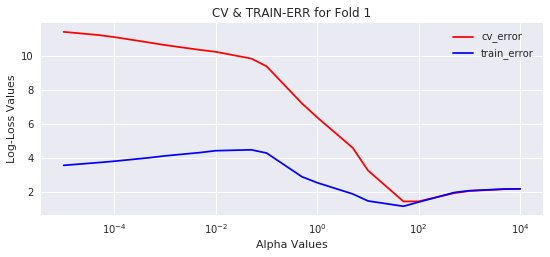

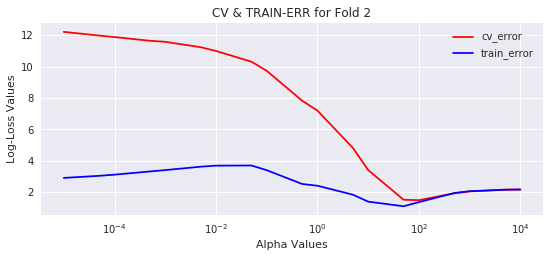

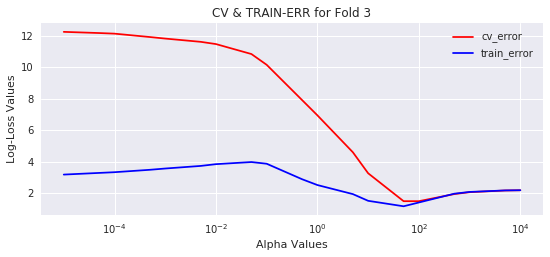

In [157]:
naive_bayes_model(complete_data, y_true, 'Training', 'OneHotEncode')

Log-Loss for Train-set is : 1.3769980789060545
Log-Loss for Test-set is : 1.5276913935250294
Train Accuracy is : 0.338855421686747
Test Accuracy is : 0.469172932330827
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


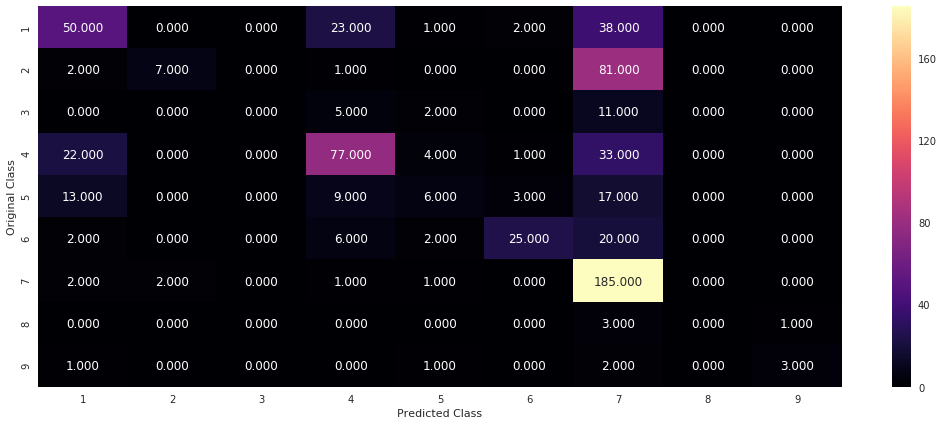

---------------------------------------- PRECISION-MATRIX ----------------------------------------


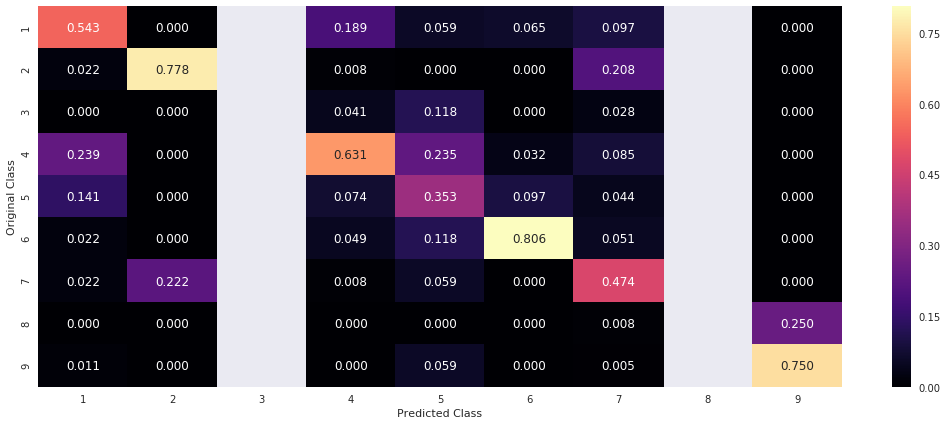

---------------------------------------- RECALL-MATRIX ----------------------------------------


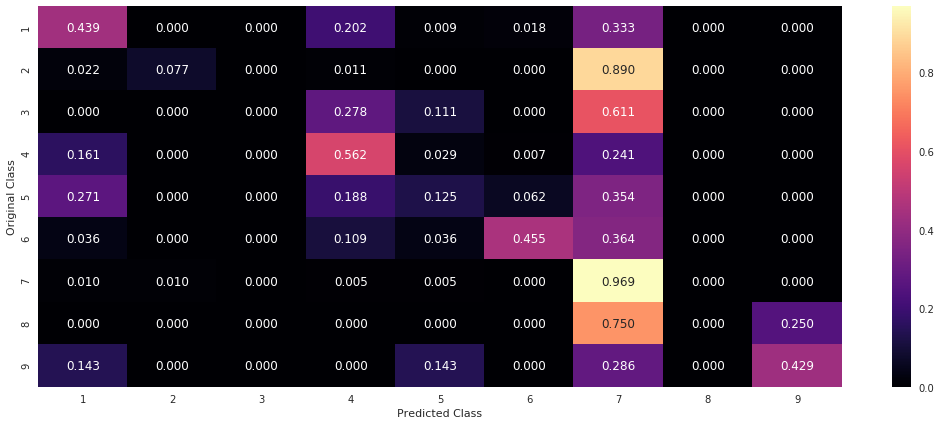

Predicted Class :  6
Actual Class :  6
----------------------------------------
1
0
0
0
0
0
0
0.2182178902359924
0.1889822365046136
0.21101669574907136
0.2344759308155899
0.23735633163877065
0.20780942610628922
0.2773500981126146
0.23112163810314532
0.2773500981126145
0.18257418583505536
0.2773500981126146
0.23717082451262844
0.23570226039551587
0.2672612419124244
0.28867513459481287
0.28190459144096375
0.2851809954967069
0
0.28867513459481287
0.26940795304016235
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2773500981126146
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129
0.2886751345948129


In [167]:
naive_bayes_model(complete_data, y_true, 'Testing', 'OneHotEncode', 100)

In [ ]:
nb_query(complete_data, y_true, 100, 1)

### 8.2 KNN

In [145]:
def knn_model(data, ydata, operation, encode_type, best_k = None):
    
    train_x, test_x, train_y, test_y = data_split(data, ydata)
    k_fold = StratifiedKFold(train_y, shuffle = True, random_state = 12)
    
    k_val = np.arange(2, 50, 3)
    if operation == 'Training':
        cv_err = []
        train_err = []
        for train, cv in k_fold:
            if encode_type == 'OneHotEncode':
                trn_data, cv_data = feature_stack(train_x.iloc[train], train_y[train], train_x.iloc[cv], train_y[cv], encode_type)
            else:
                trn_data, cv_data = feature_stack(train_x.iloc[train], train_y[train], train_x.iloc[cv], train_y[cv], encode_type)
            for k in k_val:
                clf = KNeighborsClassifier(n_neighbors = k, weights = 'distance', n_jobs = -1)
                clf.fit(trn_data, train_y[train])
                pred_proba_trn = clf.predict_proba(trn_data)
                pred_proba_cv = clf.predict_proba(cv_data)
                train_err.append(log_loss(train_y[train], pred_proba_trn))
                cv_err.append(log_loss(train_y[cv], pred_proba_cv))
        train_err = np.reshape(train_err, (3, len(k_val)))
        cv_err = np.reshape(cv_err, (3, len(k_val)))
        err_compare(train_err, cv_err, k_val, 'K')
    else:
        clf = KNeighborsClassifier(n_neighbors = best_k)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        pred_proba_trn = clf.predict_proba(trn_data)
        pred_proba_tst = clf.predict_proba(tst_data)
        trn_err = (1 - clf.score(trn_data, train_y))
        tst_err = (1 - clf.score(tst_data, test_y))
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))
        '''  
        data_indx = 1
        num_feature = 100
        pred_cls = clf.predict(tst_data.iloc[data_indx].reshape(1, -1))
        print('Predicted Class : ', pred_cls[0])
        print('Actual Class : ', test_y[data_indx])
        sorted_indices = np.argsort(-clf.coef_)[pred_cls - 1][:, :num_feature]
        print(type(sorted_indices))
        print("-"*40)
        for i in sorted_indices:
            print(tst_data.columns[i])
        print(type(i))
        print(i)
        for i in sorted_indices:
            print(tst_data[tst_data.columns[i]][data_indx])
        '''
        #gene_cat = np.unique(trn_data['Gene'])
        #var_cat = np.unique(trn_data['Variation'])
        #for i in

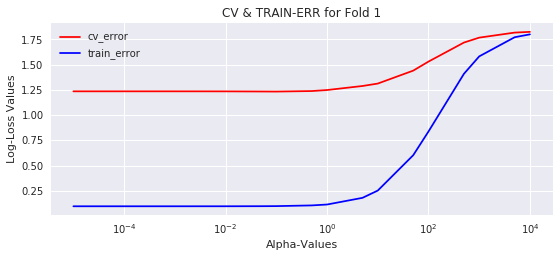

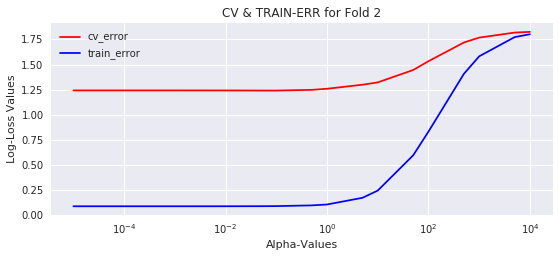

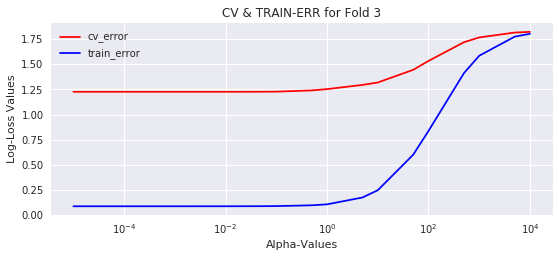

In [429]:
naive_bayes_model(complete_data, y_true, 'Training', 'ResponseEncode')

Log-Loss for Train-set is : 1.6730151048783017
Log-Loss for Test-set is : 1.7878998331165739
Train Accuracy is : 0.7131024096385542
Test Accuracy is : 0.7127819548872181
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


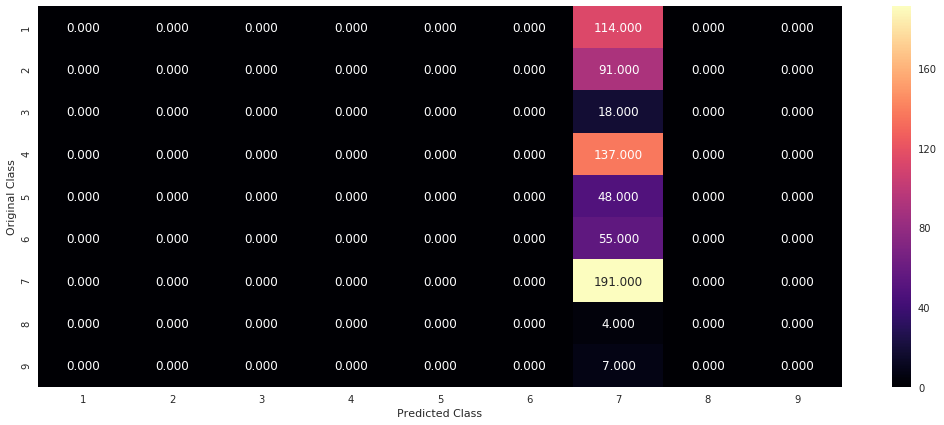

---------------------------------------- PRECISION-MATRIX ----------------------------------------


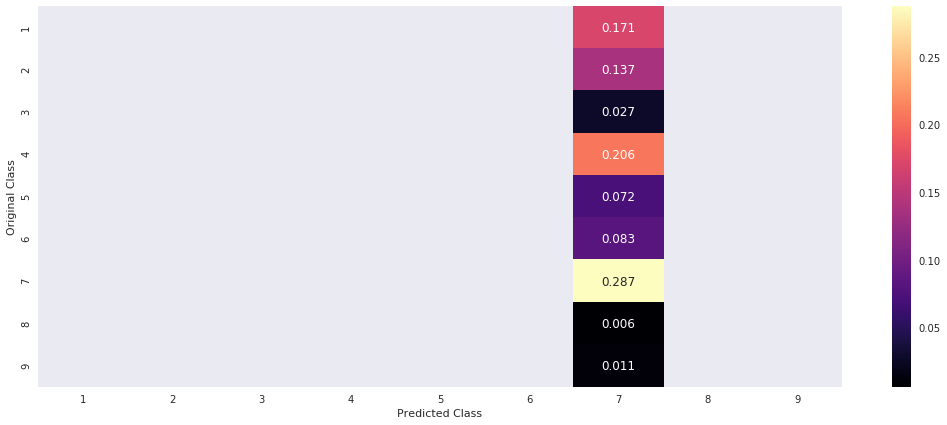

---------------------------------------- RECALL-MATRIX ----------------------------------------


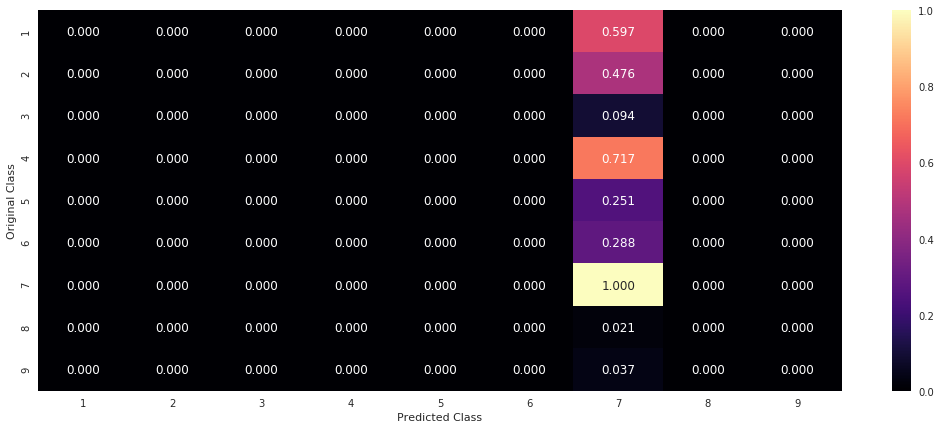

In [449]:
naive_bayes_model(complete_data, y_true, 'Testing', 'ResponseEncode', 2500)

Log-Loss for Train-set is : 0.0914538898679334
Log-Loss for Test-set is : 1.7611355947498597
Train Accuracy is : 0.028237951807228878
Test Accuracy is : 0.41203007518796997
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


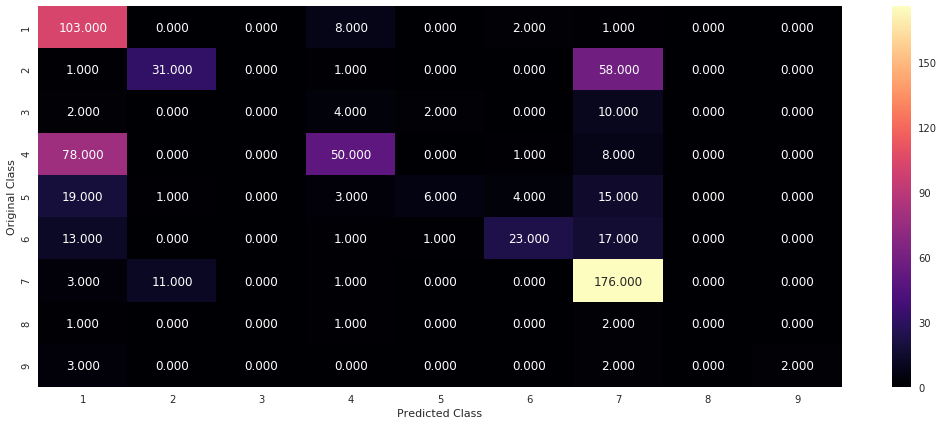

---------------------------------------- PRECISION-MATRIX ----------------------------------------


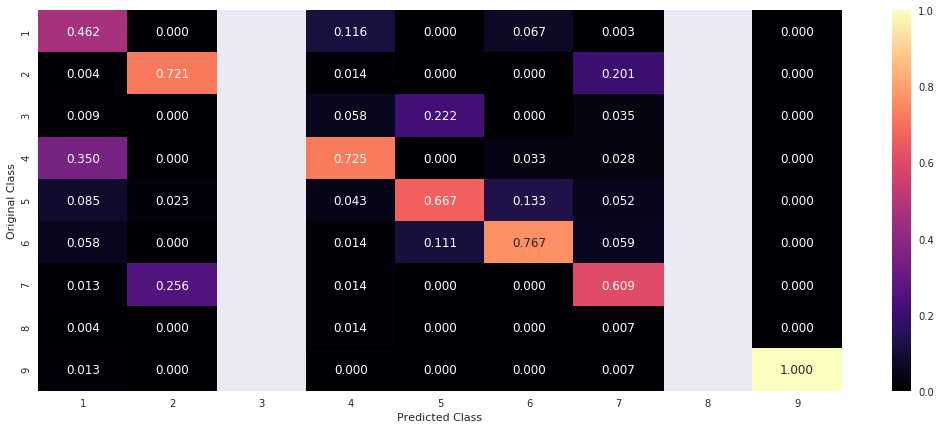

---------------------------------------- RECALL-MATRIX ----------------------------------------


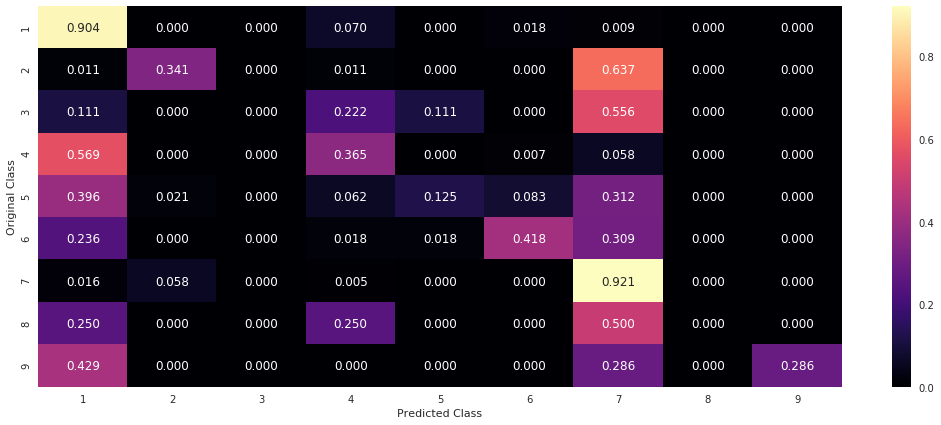

In [169]:
knn_model(complete_data, y_true, 'Testing', 'ResponseEncode', 100)